# Домашнее задание
### по теме «ARIMA / SARIMA алгоритмы для сезонных timescale данных»

### Загрузка библиотек

In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import missingno as msno

### Загрузка и подготовка данных

In [103]:
df = pd.read_csv('data/data_beer.csv')
df.head(5)

,Month,Monthly beer production
0,1956-01,93.2
1,1956-02,96.0
2,1956-03,95.2
3,1956-04,77.1
4,1956-05,70.9


Проверка на пропуски

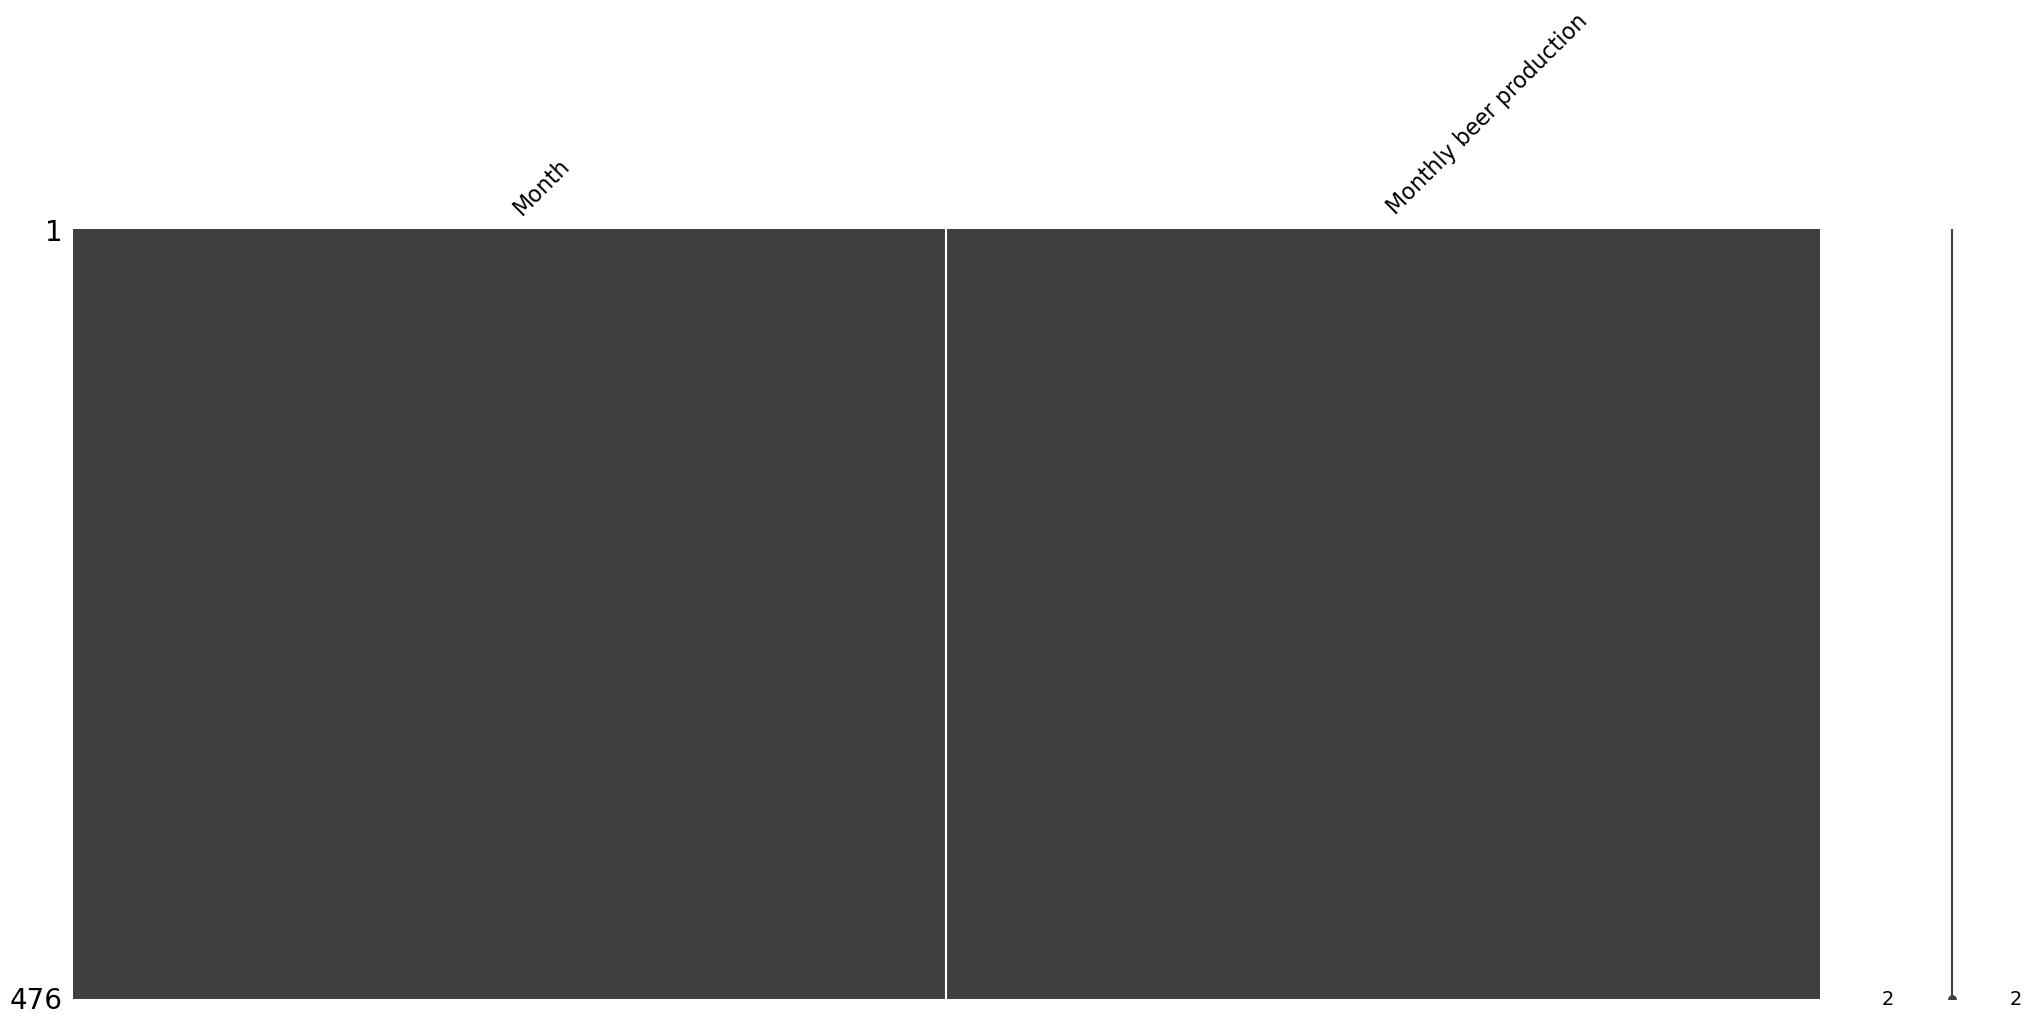

In [104]:
msno.matrix(df)
plt.show()

Пропусков нет

In [105]:
df['Month'] = pd.date_range(start='1956-01', periods=len(df), freq='ME') # Добавление крайнего дня месяца
df.set_index('Month', inplace=True) # Установка даты индексом
df.columns = ['Production'] # Переименование столбца с данными
df.head()

,Production
Month,
1956-01-31,93.2
1956-02-29,96.0
1956-03-31,95.2
1956-04-30,77.1
1956-05-31,70.9


In [106]:
df.describe()

,Production
count,476.000000
mean,136.395378
std,33.738725
min,64.800000
25%,112.900000
50%,139.150000
75%,158.825000
max,217.800000


Анализ выбросов

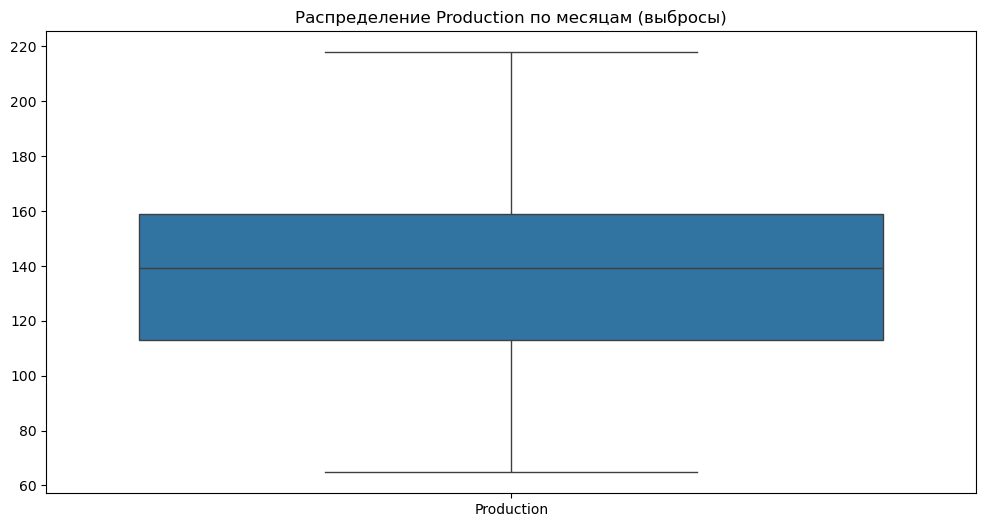

In [107]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df)
plt.title('Распределение Production по месяцам (выбросы)')
plt.show()

Визуально выбросов нет

### Визуализация трендов и сезонности

Линейный график

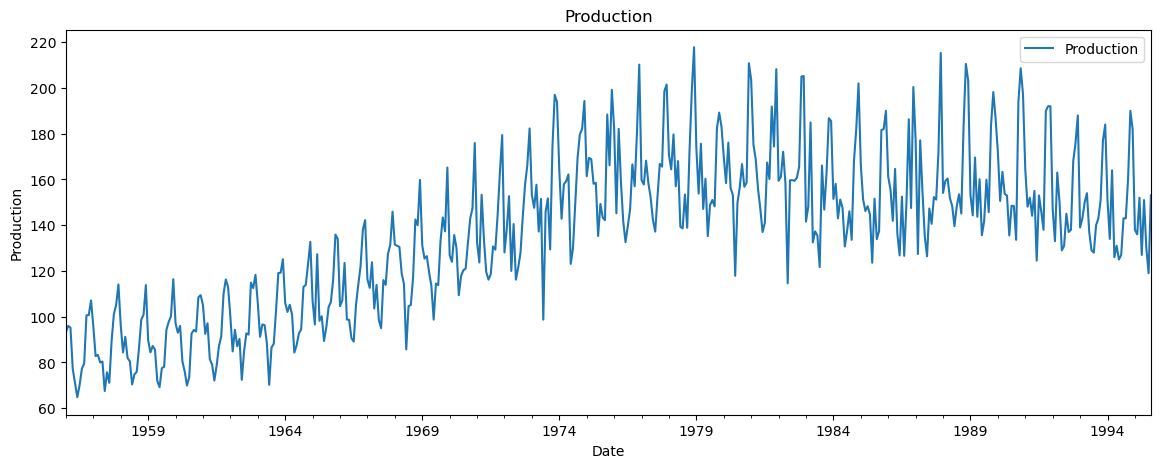

In [108]:
df.plot(figsize=(14,5), title="Production")
plt.ylabel("Production")
plt.xlabel("Date")
plt.show()

### Простое скользящее среднее (SMA)

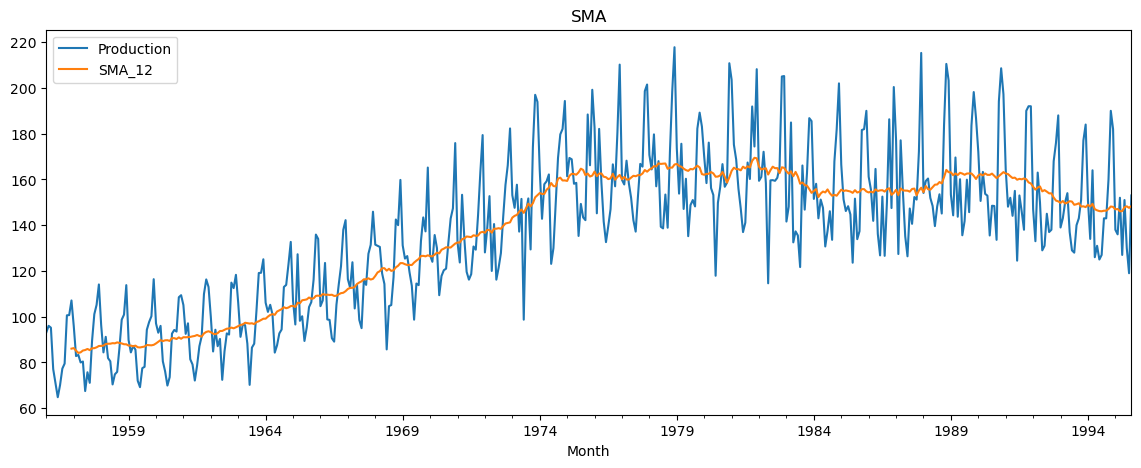

In [109]:
df_trend = df.copy()
df_trend['SMA_12'] = df_trend['Production'].rolling(window=12).mean()  # Окно 12 кратно месяцам в году
df_trend.plot(figsize=(14,5), title="SMA")
plt.show()

- Просматривается сезонность в течении года
- Тенденция на рос до середины 1975 года, далее выравнивание с небольшими колебаниями

### Декомпозиция

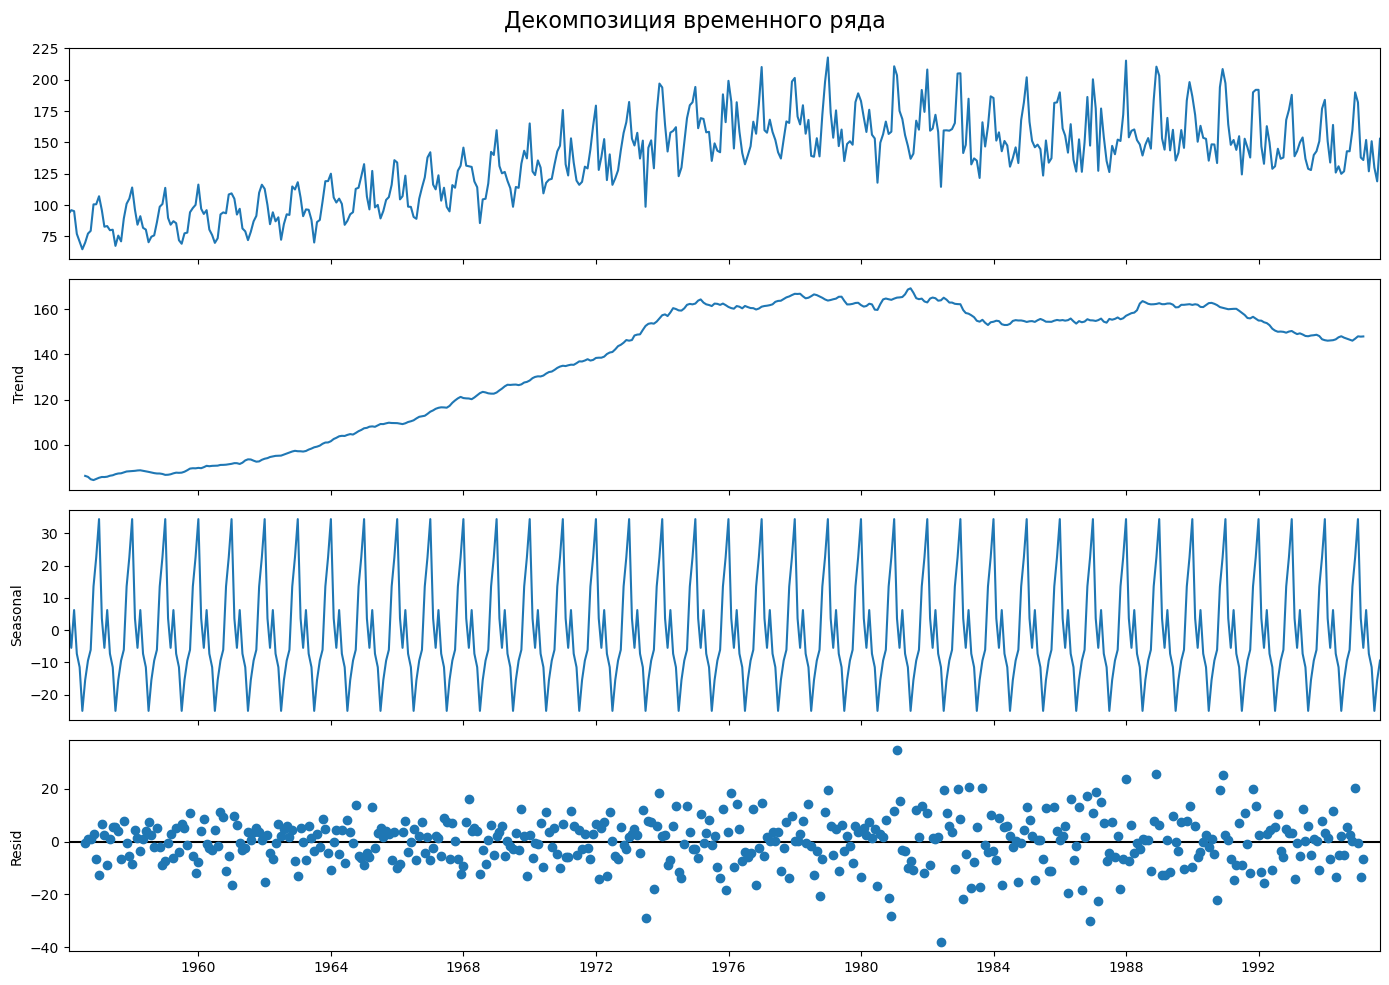

In [110]:
plt.rcParams['figure.figsize'] = (14, 10)
decomposition = seasonal_decompose(df, model='additive')
decomposition.plot()
plt.suptitle("Декомпозиция временного ряда", fontsize=16)
plt.tight_layout()
plt.show()

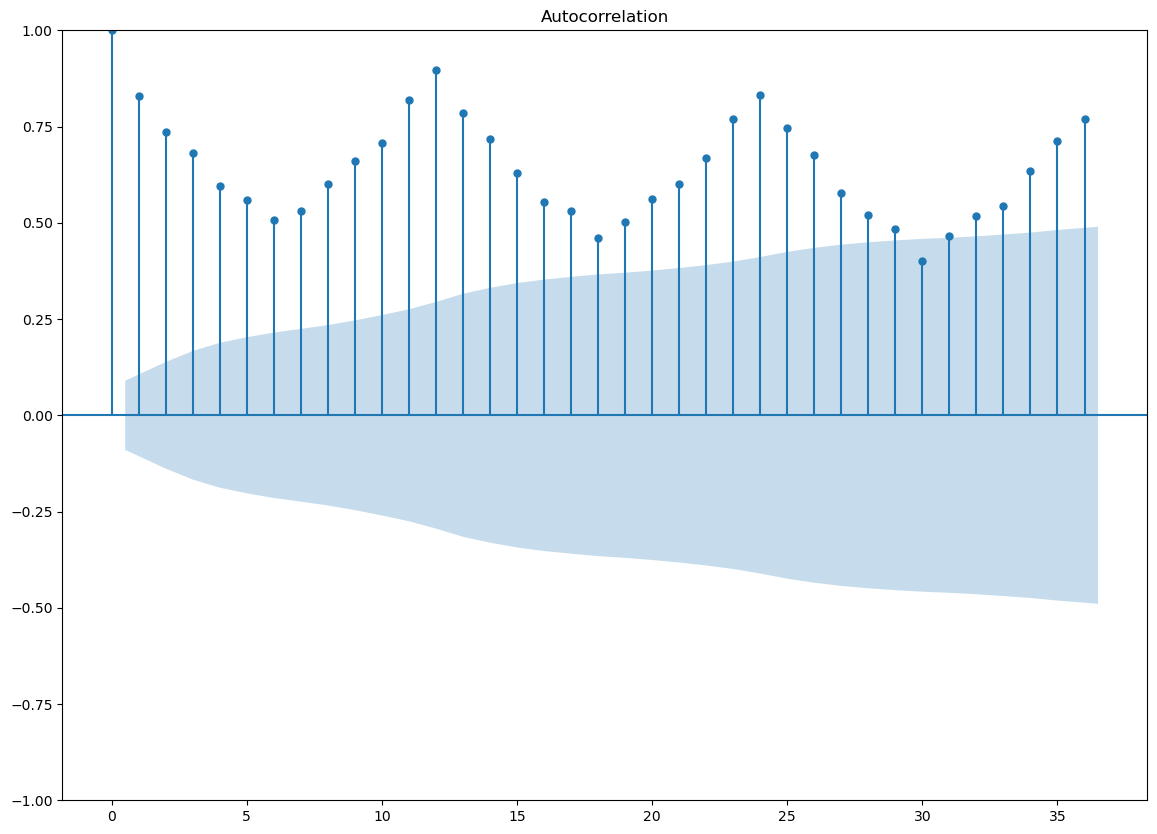

In [111]:
# Определение m
plot_acf(df['Production'], lags=36)
plt.show()

Принимаю m =12

In [112]:
trend_part = decomposition.trend
seasonal_part = decomposition.seasonal
residual_part = decomposition.resid

print("Ранние значения:")
print(residual_part.head())
print("\nПоздние значения:")
print(residual_part.tail())

residual_part_clean = residual_part.dropna()

Ранние значения:
Month
1956-01-31   NaN
1956-02-29   NaN
1956-03-31   NaN
1956-04-30   NaN
1956-05-31   NaN
Name: resid, dtype: float64

Поздние значения:
Month
1995-04-30   NaN
1995-05-31   NaN
1995-06-30   NaN
1995-07-31   NaN
1995-08-31   NaN
Name: resid, dtype: float64


Выделены тренд, сезонность и остатки

### Тест Дики-Фуллера (ADF)

In [113]:
# Проверка на стационарность
adf_result = sm.tsa.adfuller(df['Production'].dropna())
print(f"p-value: {adf_result[1]:.4f}")

p-value: 0.1776


Требуется дифференцирование

p-value: 0.0000


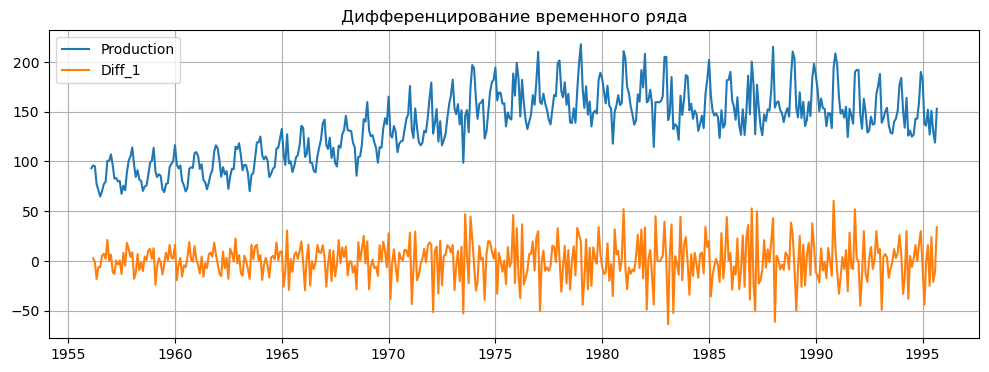

In [114]:
df['Diff_1'] = df['Production'].diff()

adf_result = sm.tsa.adfuller(df['Diff_1'].dropna())
print(f"p-value: {adf_result[1]:.4f}")
# Визуализация
plt.figure(figsize=(12,4))
plt.plot(df['Production'], label='Production')
plt.plot(df['Diff_1'], label='Diff_1')
plt.title('Дифференцирование временного ряда')
plt.legend()
plt.grid(True)
plt.show()

Стационарность ряда достигнута при d = 1

### Подбор параметров auto_arima

In [115]:
# Разделение на тренировочную и тестовую выборки
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

In [116]:
import warnings
warnings.filterwarnings("ignore") # Куча ошибок не влияющих на работу - отключу пока

model_auto = auto_arima(train['Production'],
                        seasonal=True, 
                        m=12,
                        suppress_warnings=True, 
                        trace=False, 
                        error_action='ignore',
                        stepwise=False)


In [117]:
print(model_auto.summary())
p, d, q = model_auto.order
P, D, Q, m = model_auto.seasonal_order

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  380
Model:             SARIMAX(0, 1, 3)x(1, 0, [1], 12)   Log Likelihood               -1413.477
Date:                              Sat, 05 Apr 2025   AIC                           2840.955
Time:                                      19:19:00   BIC                           2868.517
Sample:                                  01-31-1956   HQIC                          2851.893
                                       - 08-31-1987                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0004      0.003      0.120      0.905      -0.006       0.007
ma.L1         -1.06

In [118]:
# Коэффициенты после автоподбора
print(f"Подобранные коэффициенты: \np = {p}  \nd = {d} \nq = {q} \nP = {P} \nd = {D} \nQ = {Q} \nm = {m}")

Подобранные коэффициенты: 
p = 0  
d = 1 
q = 3 
P = 1 
d = 0 
Q = 1 
m = 12


### ARIMA

In [119]:
# Обучение модели ARIMA с подобранными параметрами
arima_model = ARIMA(train['Production'], order=(p, d, q))
arima_fit = arima_model.fit()

### SARIMA

In [120]:
# Обучение модели SARIMA с подобранными параметрами
sarima_model = SARIMAX(train['Production'], 
              order=(p, d, q),
              seasonal_order=(P, D, Q, m))
sarima_fit = sarima_model.fit()

In [121]:
warnings.filterwarnings("default") # err-on

### Сравнение алгоритмов

In [122]:
# Прогнозирование на тестовой выборке ARIMA
forecast_steps_a = len(test)
forecast_a = arima_fit.get_forecast(steps=forecast_steps_a)
forecast_val_a = forecast_a.predicted_mean 
conf_int = forecast_a.conf_int()       

# Прогнозирование на тестовой выборке SARIMA
forecast_steps_s = len(test)
forecast_s = sarima_fit.get_forecast(steps=forecast_steps_s)
forecast_val_s = forecast_s.predicted_mean
conf_int = forecast_s.conf_int()

# RMSE
rmse_arima = sqrt(mean_squared_error(test['Production'], forecast_val_a))
rmse_sarima = sqrt(mean_squared_error(test['Production'], forecast_val_s))
print(f"RMSE: \nARIMA={rmse_arima:.2f} | SARIMA = {rmse_sarima:.2f}")

# MAPE
mape_arima = np.mean(np.abs((test['Production'] - forecast_val_a) / test['Production'])) * 100
mape_sarima = np.mean(np.abs((test['Production'] - forecast_val_s) / test['Production'])) * 100
print(f"\nMAPE: \nARIMA={mape_arima:.2f}% | SARIMA = {rmse_sarima:.2f}%")

RMSE: 
ARIMA=22.08 | SARIMA = 12.23

MAPE: 
ARIMA=10.27% | SARIMA = 12.23%


- RMSE SARIMA значительно лучше RMSE ARIMA
- MAPE ARIMA немного лучше SARIMA. Можно предположить, что у ARIMA были меньшие ошибки на малых значениях, но большие на крупных

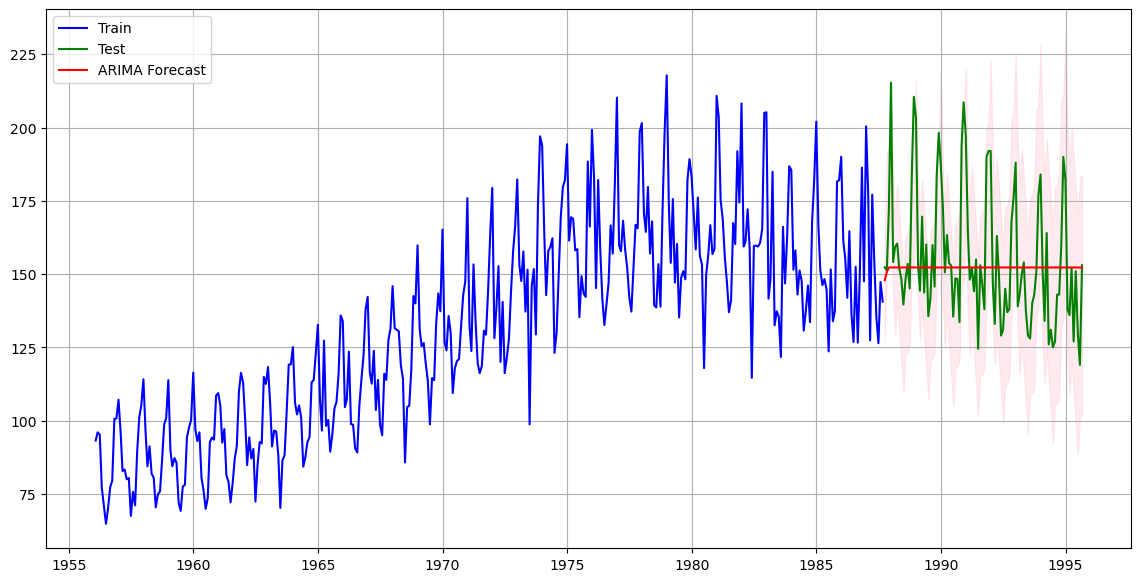

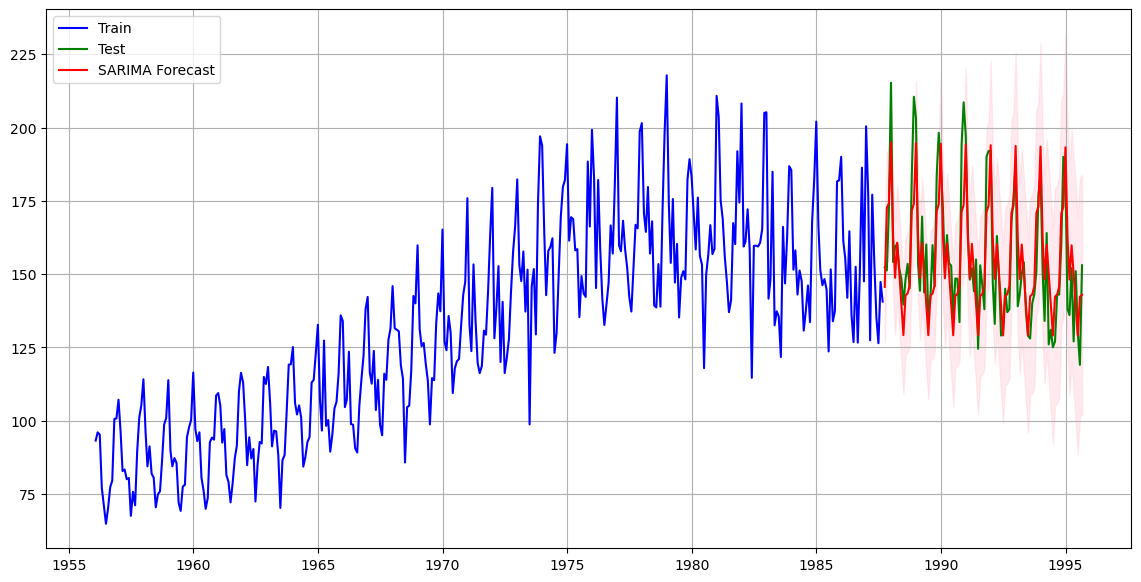

In [123]:
# Визуализация результатов ARIMA
plt.figure(figsize=(14, 7))
plt.plot(train.index, train['Production'], label='Train', color='blue')
plt.plot(test.index, test['Production'], label='Test', color='green')
plt.plot(test.index, forecast_val_a, label='ARIMA Forecast', color='red')
plt.fill_between(test.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.legend()
plt.grid(True)
plt.show()

# Визуализация SARIMA
plt.figure(figsize=(14, 7))
plt.plot(train.index, train['Production'], label='Train', color='blue')
plt.plot(test.index, test['Production'], label='Test', color='green')
plt.plot(test.index, forecast_val_s, label='SARIMA Forecast', color='red')
plt.fill_between(test.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.legend()
plt.grid(True)
plt.show()

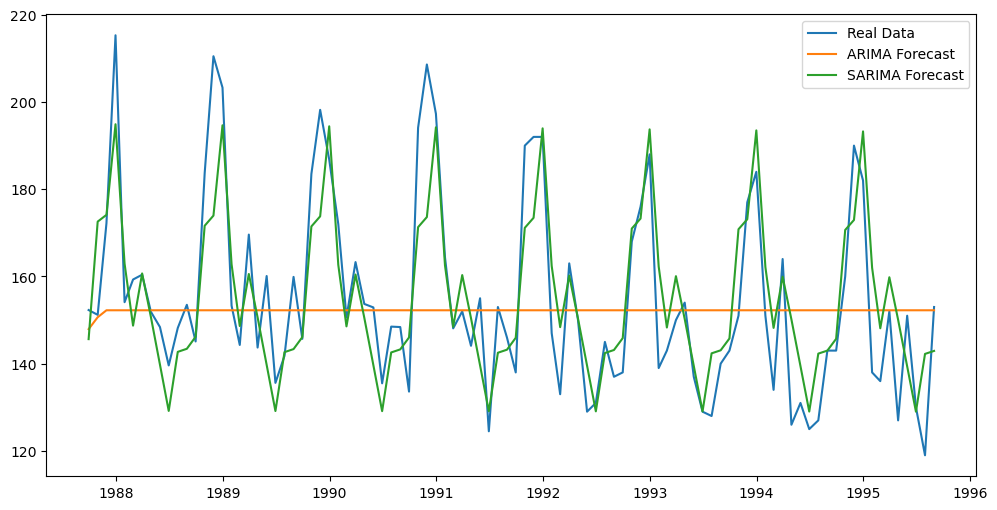

In [124]:
# Общий грфик ошибок
plt.figure(figsize=(12, 6))
plt.plot(test['Production'], label='Real Data')
plt.plot(forecast_val_a, label='ARIMA Forecast')
plt.plot(forecast_val_s, label='SARIMA Forecast')
plt.legend()
plt.show()

- ARIMA - не учитывает колебания тестовых данных от слова совсем
- SARIMA - хорошо приближается к тестовым данным

Анализ остатков

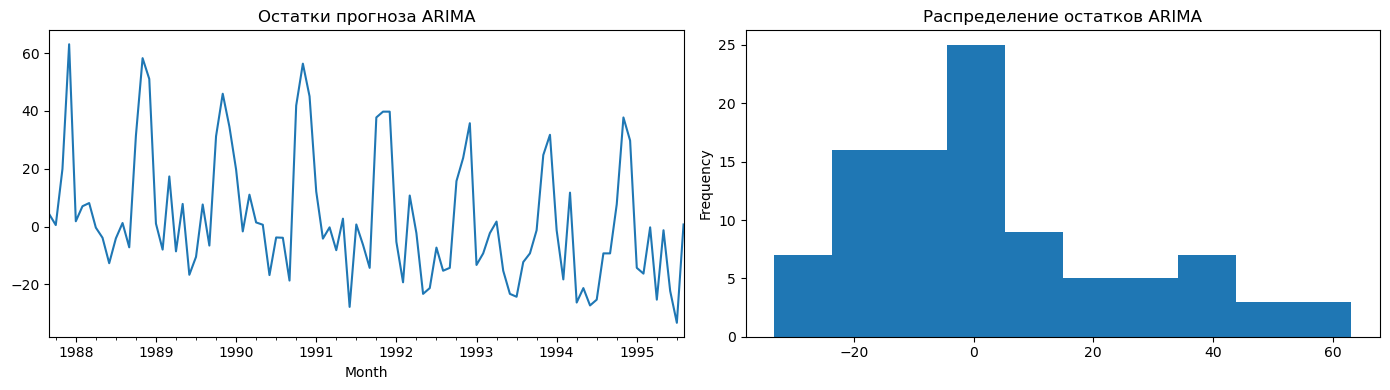

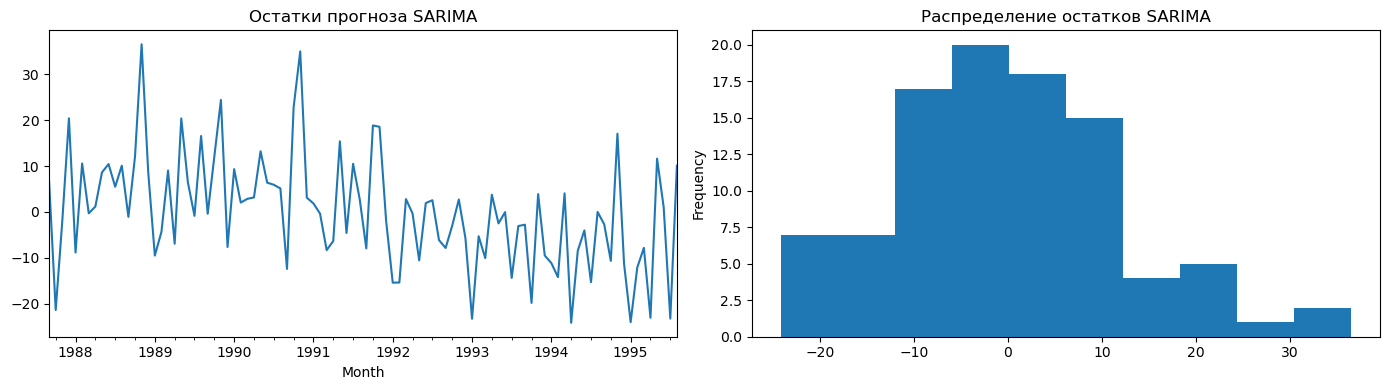

In [125]:
# Анализ остатков ARIMA
residuals = test['Production'] - forecast_val_a
plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
residuals.plot(title='Остатки прогноза ARIMA')
plt.subplot(1, 2, 2)
residuals.plot(kind='hist', title='Распределение остатков ARIMA')
plt.tight_layout()
plt.show()

# Анализ остатков SARIMA
residuals = test['Production'] - forecast_val_s
plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
residuals.plot(title='Остатки прогноза SARIMA')
plt.subplot(1, 2, 2)
residuals.plot(kind='hist', title='Распределение остатков SARIMA')
plt.tight_layout()
plt.show()

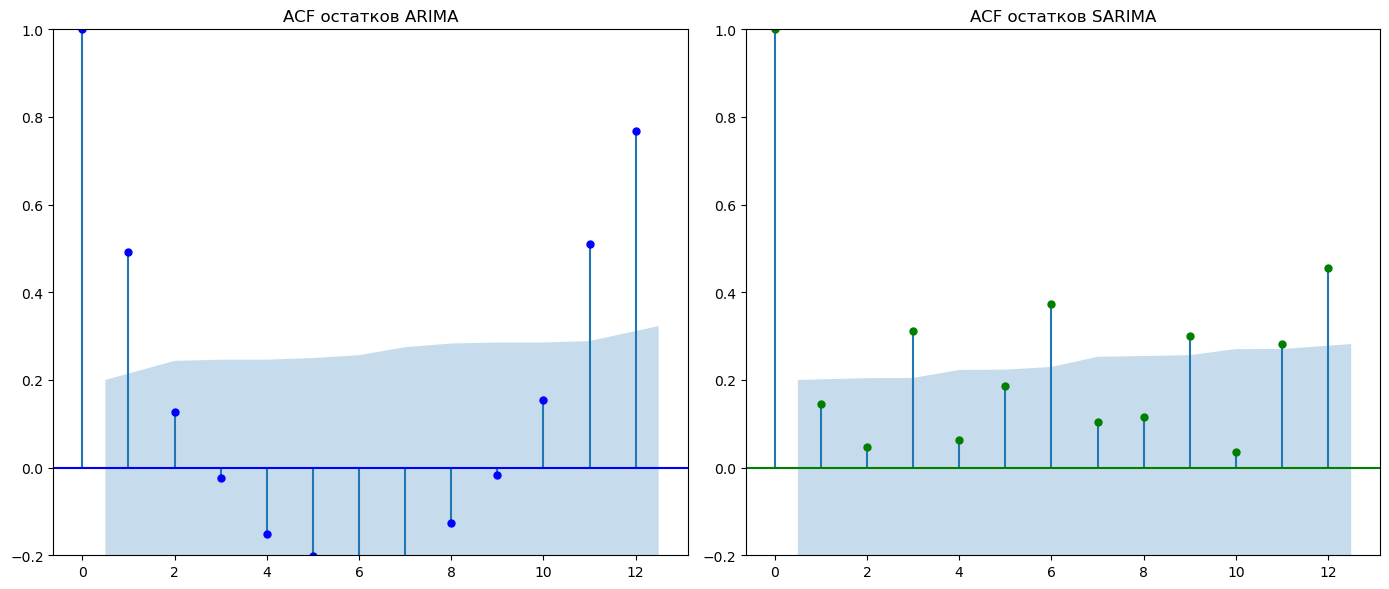

In [ ]:
# Остатки ARIMA
residuals_arima = test['Production'] - forecast_val_a

# Остатки SARIMA
residuals_sarima = test['Production'] - forecast_val_s

# Визуализация
plt.figure(figsize=(14, 6))

# ARIMA
plt.subplot(1, 2, 1)
plot_acf(residuals_arima, lags=12, ax=plt.gca(), 
         title='ACF остатков ARIMA', color='blue')
plt.ylim(-0.2, 1)
# SARIMA
plt.subplot(1, 2, 2)
plot_acf(residuals_sarima, lags=12, ax=plt.gca(), 
         title='ACF остатков SARIMA', color='green')
plt.ylim(-0.2, 1)

plt.tight_layout()
plt.show()

SARIMA показывает лучшие результаты в части остатков
- меньшие значения ошибок;
- более компактное распределение с меньшими выбросами;
- меньшая автокорреляция остатков.

## Выводы
1. SARIMA значительно лучше ARIMA по всем показателям.

2. ARIMA демонстрирует полную неадекватность.

3. SARIMA показывает хорошие результаты, но требует доработки для устранения автокорреляции.